In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm, metrics
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV, train_test_split
from skimage.io import imread
from skimage.transform import resize
from skl2onnx import to_onnx
import onnxruntime as rt


In [2]:
def load_image_files(images_dir_path, dimension=(224, 224)):
    images_dir = Path(images_dir_path)
    directories = [directory for directory in images_dir.iterdir()]
    classes = [class_directory.name.lower() for class_directory in directories]

    train_data = []

    for class_index, directory in enumerate(directories):
        for file in directory.iterdir():
            image = imread(file)
            image_resized = resize(image, dimension, anti_aliasing=True, mode='reflect')
            image_flat = image_resized.flatten()

            train_data.append(
                Bunch(
                image=image,
                image_resized=image_resized,
                image_flat=image_flat,
                class_index=class_index,
                class_name=classes[class_index],
                )
            )

    return train_data

In [3]:
image_dataset = load_image_files("groceries", dimension=(224, 224))
# image_dataset = load_image_files("cifar-10", dimension=(64, 64))

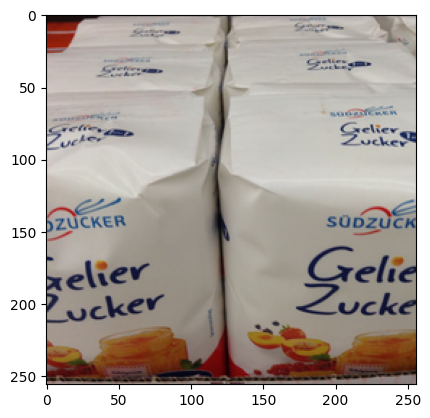

sugar


In [4]:
%matplotlib inline
plt.imshow(image_dataset[0].image)
plt.show()
print(image_dataset[0].class_name)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(
    list(map(lambda bunch: bunch.image_flat, image_dataset)), 
    list(map(lambda bunch: bunch.class_index, image_dataset)), 
    test_size=0.3,
    random_state=109
)

In [6]:
svc = svm.SVC()
svm_classifier = svc
svm_classifier.fit(x_train, y_train)

SVC()

In [7]:
y_pred = svm_classifier.predict(x_test)

In [8]:
print(
    "Classification report for - \n{}:\n{}\n".format(
        svm_classifier, 
        metrics.classification_report(y_test, y_pred)
    )
)

Classification report for - 
SVC():
              precision    recall  f1-score   support

           0       0.29      0.40      0.34        25
           1       1.00      0.03      0.05        38
           2       0.48      0.24      0.32        54
           3       0.41      0.64      0.50        84
           4       0.53      0.17      0.26        47
           5       0.24      0.19      0.21        58
           6       0.54      0.25      0.34        59
           7       0.30      0.23      0.26        47
           8       0.34      0.37      0.36        43
           9       0.26      0.38      0.31        94
          10       0.30      0.16      0.21        50
          11       0.38      0.18      0.24        51
          12       0.21      0.51      0.30        68
          13       0.37      0.17      0.24        58
          14       0.25      0.30      0.27        94
          15       0.20      0.32      0.25        93
          16       0.40      0.04      0.07  

In [9]:
onx = to_onnx(svm_classifier, x_train[0])
with open("svm_groceries_224_224_3.onnx", "wb") as f:
# with open("svm_cifar10_64_64_3.onnx", "wb") as f:
    f.write(onx.SerializeToString())

In [10]:
session = rt.InferenceSession("svm_groceries_224_224_3.onnx", providers=["CPUExecutionProvider"])
# session = rt.InferenceSession("svm_cifar10_64_64_3.onnx", providers=["CPUExecutionProvider"])
input_name = session.get_inputs()[0].name
session.run(None, {input_name: np.array(x_test)[0]})[0][0]

InvalidProtobuf: [ONNXRuntimeError] : 7 : INVALID_PROTOBUF : Load model from svm_groceries_224_224_3.onnx failed:Protobuf parsing failed.